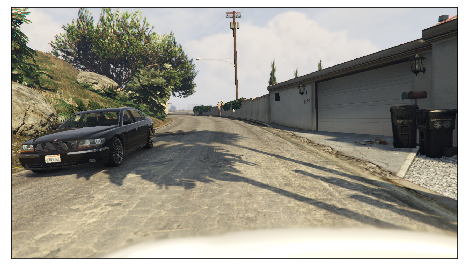

In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from tqdm.notebook import tqdm

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2

import numpy as np

import sys
sys.path.append('../')

from depth_Functions import (
    import_raw_colour_image, 
    show_img, 
    show_array_of_images,
    show_function
)
    
from Feature_Extraction import ( 
    sum_and_square_sums
)

from Patches import Patches

bgr = import_raw_colour_image('../GTA_images/Simple/Colour/color_1.raw')
show_img(bgr)

# Theory

In accordance with [3-D Depth Reconstruction from a Single Still Image](https://www.cs.cornell.edu/~asaxena/learningdepth/ijcv_monocular3dreconstruction.pdf) determining the depth of a patch is better defined using information of it's suroundings

## Factors:

### Neighbour comparison

To features of adjacent patches are considered in calcualting the depth of a patch

### Scale:

How the features of a patch changes with scale can indicate it's properties i.e. differentiate grass from sky

### Column comparison

Assuming the image is of the real world, or at least a representation that mimics it, it is possible to use known common characteritics as part of our analysis

In the real world we know that structures do not float and therefore  information can be contained in the vertical column the patch lies in

## Our implementation

To utilise these factors we add multiply our feature vector to contain:
1. The features in the adjacent patches
1. The features of the patch and neighbouring patchs at increased scales
1. The features of the columns

We define:

|||
|-|-|
|Neighbours|Adjacent patches|
|Scales| $1\times1,\ 3\times3,\ 9\times9 $ |
|Columns|4 columns from top to bottom of the image|

In total the global feature vector has a length of $19\times34$: 

$$length =646$$

# Adding global features

To more easily visualise the product of these functions we will experiment on the Greyscale.

patchsize = [240, 320]
dimensions = [('patch', 1, 1), ('column', 1, 1), ('patch', 3, 3), ('patch', 9, 9)]
shape = (3, 4, 4, 5, 3)


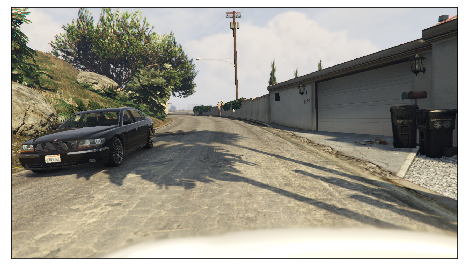

In [316]:
visual = Patches(bgr, (240,320), (3,), function=lambda patch : np.mean(patch, axis=(0,1)), dtype=np.uint8)

## Neighbouring patches

We create our patches, the neighbour feature vectors are set to the patches vector

**n.b.** this means edge/corner patches will have their own feature vector recorded as unavailable patches.

e.g. Top left will record left and above neighbour as it's own feature vector

In [317]:
show_function(visual.set_adjacent)

def set_adjacent(self, dim):
        for y in range(0,self.patches.shape[0]-1):
                for x in range(0,self.patches.shape[1]-1):
                    for i, (dy,dx) in enumerate(self.neighbour_order[1:]):
                        y0 = -1-y   if dy==-1 else y
                        y1 = y      if dy== 1 else -1-y
                        x0 = -1-x   if dx==-1 else x
                        x1 = x      if dx== 1 else -1-x
                        self.patches[y0, x0, dim, i+1] = self.patches[y0+dy, x0+dx, dim, 0]
                        self.patches[y1, x1, dim, i+1] = self.patches[y1+dy, x1+dx, dim, 0]

The neighbour order dictates what each position in the neighbour axis refers to. In the default case ```[(0,0),(-1,0),(0,1),(1,0),(0,-1)] ```:
0. Itself
0. The neighbour above
0. The nighbour to the right
0. The neighbour below
0. The neighbour to the left

If everything is working as expected, in the images below the pixels should show the pixel 1 in the direction given, which means the overall image will shift 1 in the opposite direction. i.e. pixel(0,1) in the up image will show the pixel in pixel(0,0) for the normal image.

In [318]:
visual.process_image(dim=0)

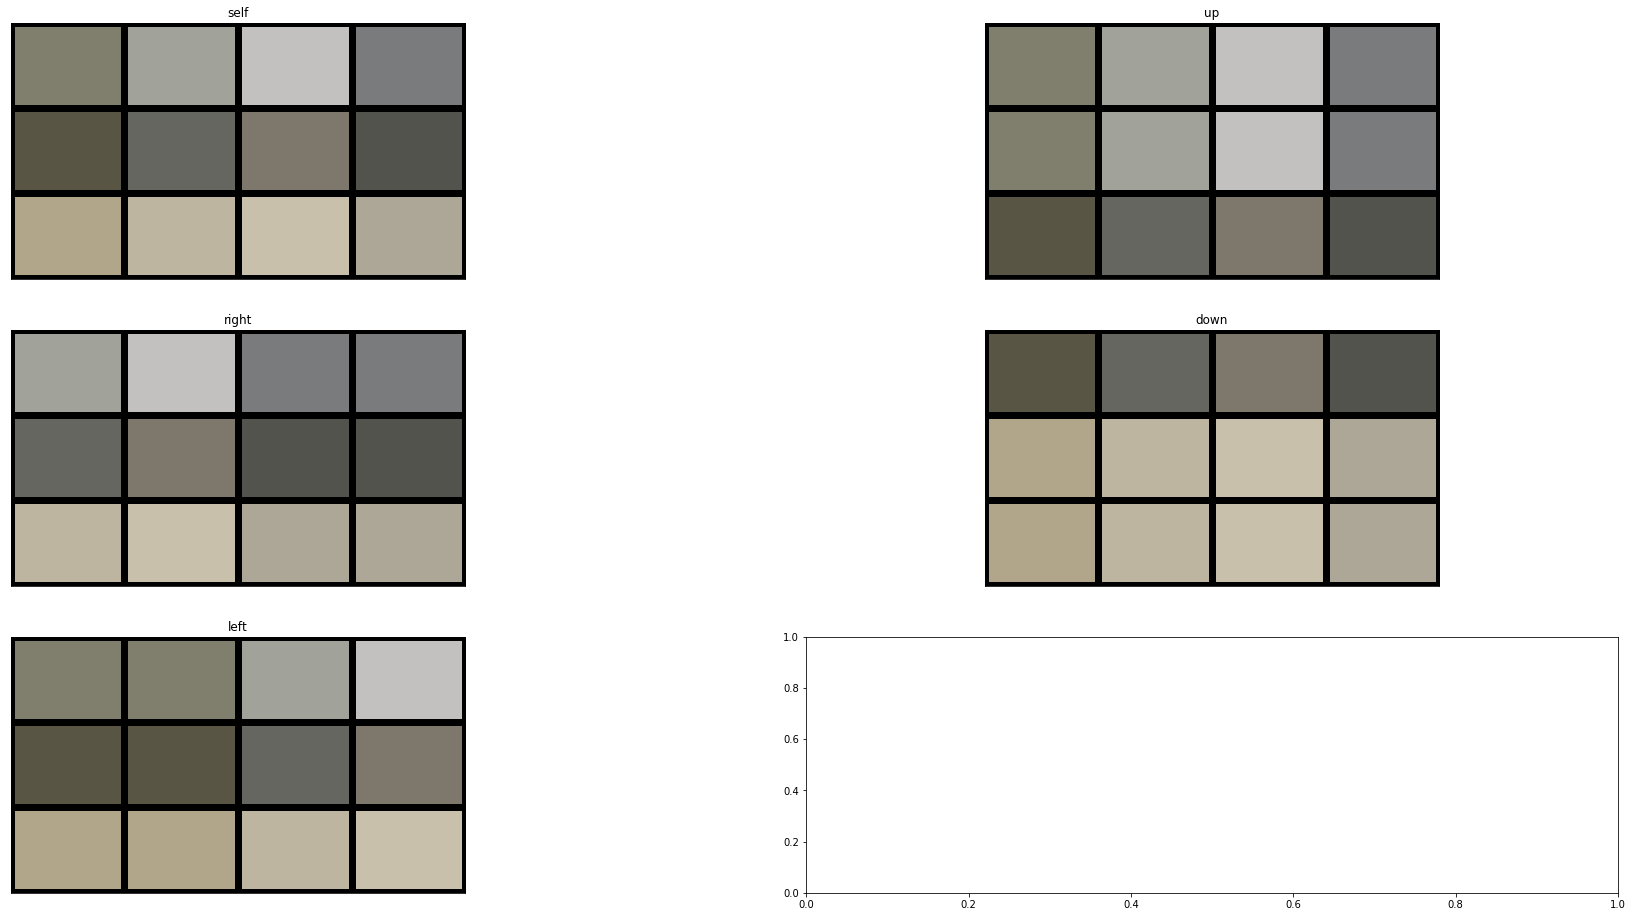

In [319]:
visual.show(neighbours=None, image_array_shape=(3,2), figsize=(16,32), 
                    titles=['self', 'up', 'right', 'down', 'left'], bordersize=10, channels=[(0,1,2)])

## Column patching:

In [320]:
visual.process_image(dim=1, name='columns')

patchsize = [144, 320]
dimensions = [('patch', 1, 1)]
shape = (5, 4, 1, 1, 3)


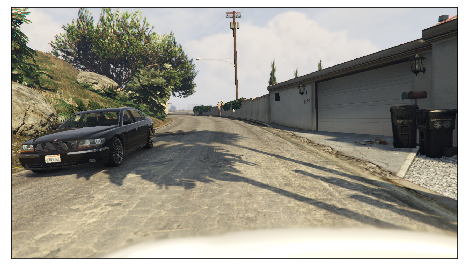

In [321]:
columns = Patches(bgr, (144,320), (3,), dimensions=[(Patches.type_patch,1,1)], neighbour_order=[(0,0)], function=lambda patch : np.mean(patch, axis=(0,1)), dtype=np.uint8)

In [322]:
columns.process_image(dim=0)

In [323]:
visual.patches.shape

(3, 4, 4, 5, 3)

In [324]:
columntest = []
for y in range(5):
    for x in range(4):
        columntest.append(visual.patches[0,x,1,y] == columns.patches[y,x,0])
    
np.all(columntest)

True

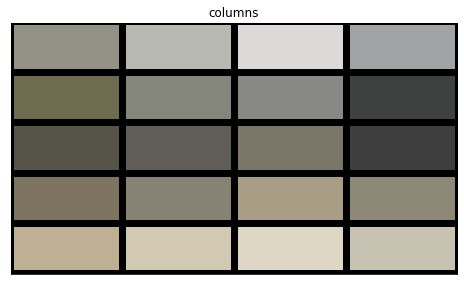

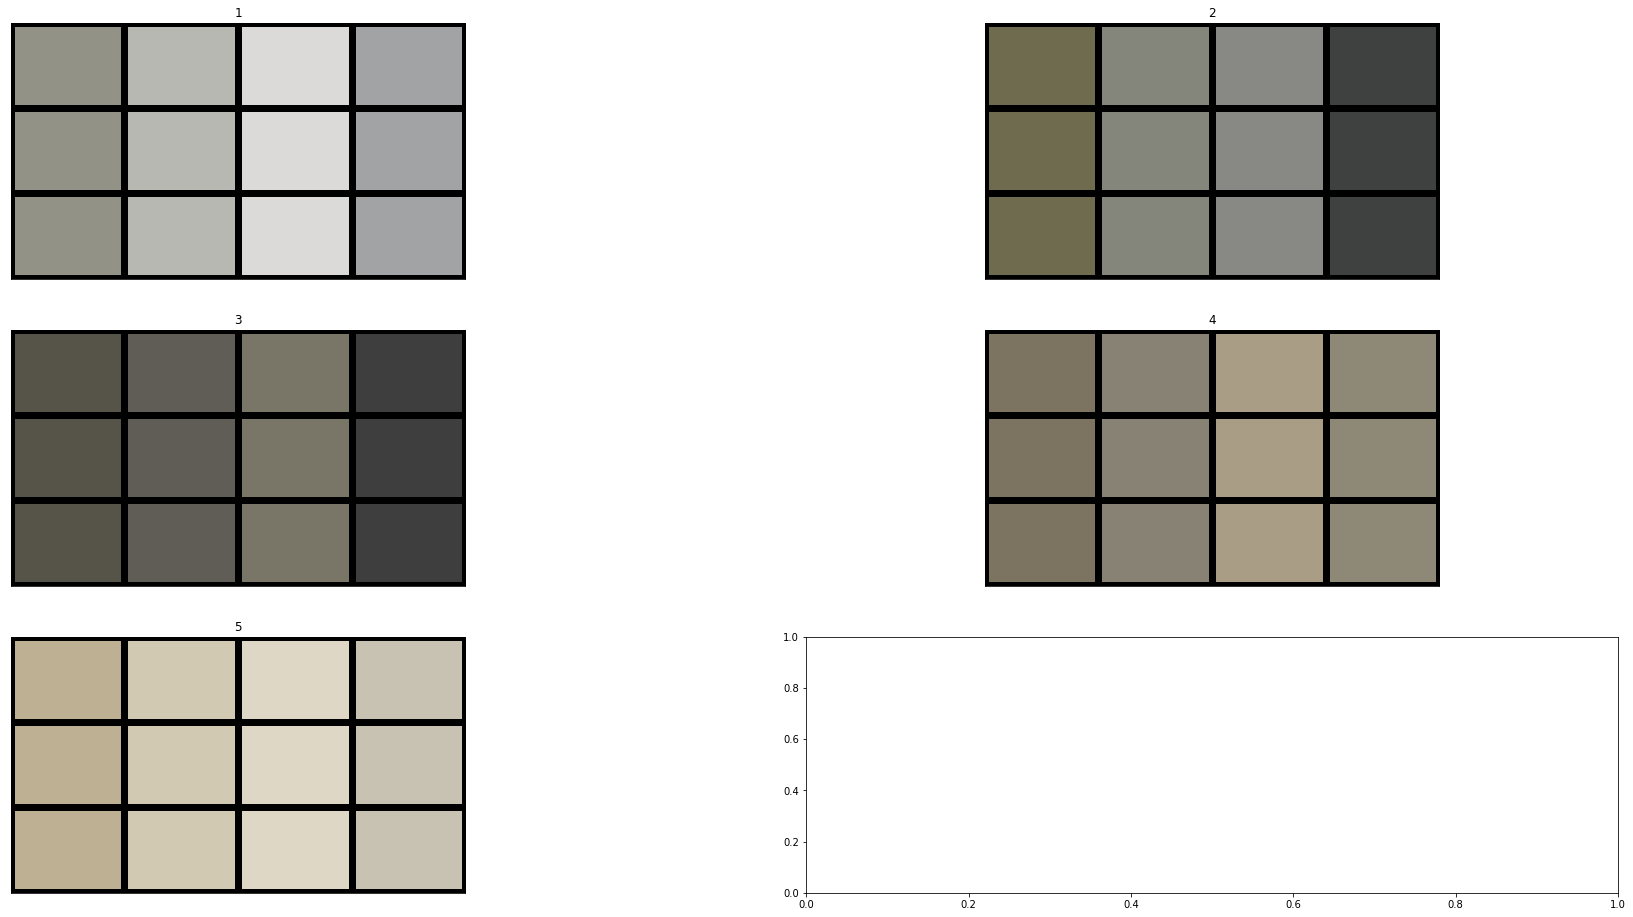

In [325]:
columns.show(dims=[0],  titles=['columns'], bordersize=10, channels=[(0,1,2)], figsize=(16,32))
visual.show(dims=[1], neighbours=None, bordersize=10, channels=[(0,1,2)], titles=[i+1 for i in range(5)], image_array_shape=(3,2), figsize=(16,32))

# Scaling

-  Scale 1x1 we have 9 feature vectors (local + 4 neighbours + 4 columns)
- At larger scales we have 5 (local + neighbours)

At larger scales 'neighbouring' subpatches are all contained within the same patch. As such there is no overlap of neighbours and they must be processed for each patch

In [326]:
visual.process_image_at_dimensions(dims=[2,3])

patchsize = [240, 320]
dimensions = [('patch', 1, 1), ('column', 1, 1), ('patch', 3, 3), ('patch', 9, 9)]
shape = (9, 12, 4, 5, 3)


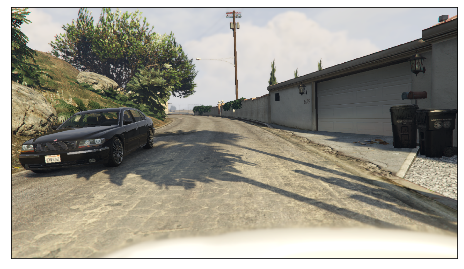

In [327]:
reference = Patches(cv2.resize(bgr, (0,0), fy=3, fx=3), (240,320), (3,), function=lambda patch : np.mean(patch, axis=(0,1)), dtype=np.uint8)

In [328]:
reference.process_image(dim=0)

The first image shows the resized image split into patches, the rest are the scaled patches of the image at the original scale. The resized images is visually split into a section of patches, the scaled features should represent the patch within those sub patches. e.g. the centre[0][0] == resized[1][1], which is the centre of the first set of patches

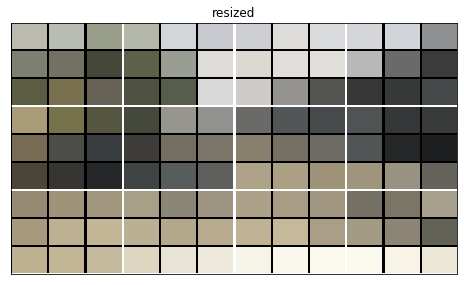

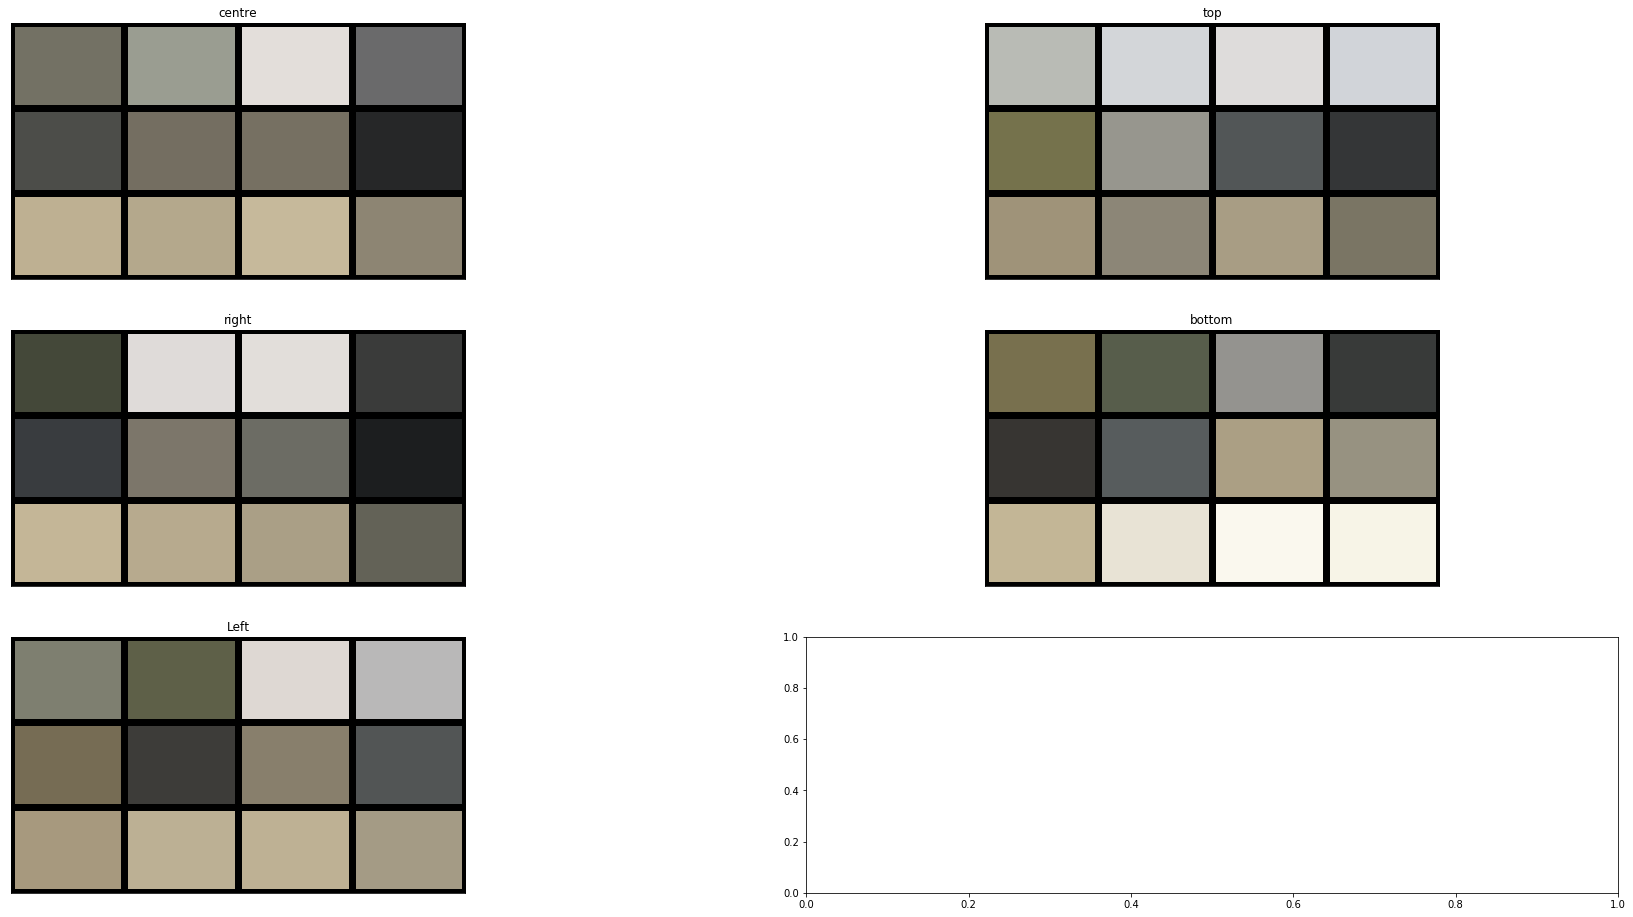

In [329]:
reference.show(bordersize=10, subborder=(3,3), channels=[(0,1,2)], titles=['resized'])
visual.show(dims=[2], neighbours=None, image_array_shape=(3,2), figsize=(16,32),  heatmap=True, titles=['centre', 'top', 'right', 'bottom', 'Left'], bordersize=10, channels=[(0,1,2)])

# Histogram of features - calculating relative depth

To calculate relative depth between patches we create a histogram of the 17 features

In [330]:
show_function(visual.set_relative)

def set_relative(self, target=None, function=None, bins=11, *args, **kwargs):
        if function is None:
            function = lambda patch : np.histogram(patch, bins=bins)[0]
        if target is None:
            target = self.patches
        
        absolute = np.apply_along_axis(function, axis=-1, arr=target[:,:,[i for i,dim in enumerate(self.dimensions) if dim[0]==self.type_patch]])
        self.relative = np.subtract(absolute[...,1:,:], absolute[...,0:1,:])

In [331]:
visual.set_relative()

In [332]:
visual.relative.shape

(3, 4, 3, 4, 11)

patchsize = [120, 160]
dimensions = [('patch', 1, 1), ('column', 1, 1), ('patch', 3, 3), ('patch', 9, 9)]
shape = (6, 8, 4, 5, 34)
patchsize = [6, 8]
dimensions = [('patch', 1, 1), ('patch', 3, 3), ('patch', 9, 9)]
shape = (120, 160, 3, 5, 17, 11)


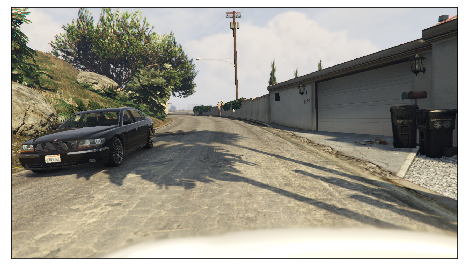

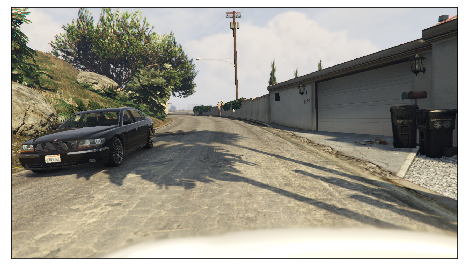

In [351]:
features = Patches(bgr, (120,160), (34,), function=create_local_feature_vector)
histogram = Patches(bgr, features.patches.shape[0:2], (17,11), dimensions=[dim for dim in visual.dimensions if dim[0]==Patches.type_patch], function=lambda patch : np.histogram(features.function(patch), bins=11)[0])

In [353]:
features.process_image_at_dimensions()

In [355]:
histogram.process_image_at_dimensions()

In [356]:
features.set_relative()

In [357]:
histogram.patches.shape

(120, 160, 3, 5, 17, 11)

In [362]:
histogram.relative = np.zeros((*histogram.patches.shape[:3],histogram.patches.shape[3]-1,*histogram.patches.shape[4:]))
for i in range(4):
    histogram.relative[:,:,:,i,:] = histogram.patches[...,i+1,:,:] - histogram.patches[...,0,:,:]

In [363]:
histogram.relative.shape

(120, 160, 3, 4, 17, 11)

In [364]:
visual.relative[0][0][0][1]
histogram.relative[0][0][0][1]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1])

array([[-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2., -2.,  0., -1., -1.],
       [-3.,  3.,  1.,  3.,  1.,  1., -2

In [347]:
visual.patches[0][0][0][0]
visual.patches[0][0][0][1]
histogram.patches[0][0][0][0]
histogram.patches[0][0][0][1]

array([110, 127, 128], dtype=uint8)

array([110, 127, 128], dtype=uint8)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.])

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.])

In [339]:
np.where(visual.relative != histogram.relative)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3

In [340]:
np.all(visual.relative == histogram.relative)

False

# Combining the information

For the Markov Random Field equation we need 2 set of information:
1. The absolute depth at each patch, which we will flatten into a 1d array
1. The histogram of depth, for calculating the relative depth

In [441]:
show_function(visual.get)

def get(self, attribute_names=['patches', 'columns', 'relative'], flatten_axis=-1, combinations=[(0,1)]):
        attributes = [getattr(self, name) for name in attribute_names]

        if flatten_axis != 0:
            attributes = [attribute.reshape(-1,*attribute.shape[flatten_axis:]) for attribute in attributes]
        
        for (first, second) in combinations:
            attributes[first] = np.concatenate((attributes[first], attributes[second]))

        return np.unique(attributes)

In [31]:
absolute = visual.get(['patches'], shape=(12,-1))

In [32]:
absolute.shape

(12, 45)

In [465]:
absolute.shape

(196, 3)